<a href="https://colab.research.google.com/github/andrei-iosif/DeepLearningStudy/blob/main/implicit_layers/Chapter_4_Deep_equilibrium_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chapter 4: Deep equilibrium models

This chapter introduces another class of emerging implicit layer models, the Deep Equilibrium (DEQ) Model [[Bai et al.,2019](https://arxiv.org/abs/1909.01377)].  These models have recently demonstrated impressive performance on a variety of large-scale vision and NLP tasks, often showing competetive performance relative to the state of the art (using traditional explicit models) [[Bai et al., 2020](https://arxiv.org/abs/2006.08656)].  However, the core idea of this approach, that of specifying a layer that finds the fixed point of some iterative procedure, dates back to some of the original work in recurrent backpropagation [[Almeida,1987](https://www.semanticscholar.org/paper/A-learning-rule-for-asynchronous-perceptrons-with-a-Almeida/8be3f21ab796bd9811382b560507c1c679fae37f), [Pineda,1987](https://papers.nips.cc/paper/1987/file/735b90b4568125ed6c3f678819b6e058-Paper.pdf)].  DEQ Models, then are largely a "modern" variant of these approach, with the conceptual additions of 1) extending these approaches using modern deep architectures, where the goal is to express the _entire_ deep network as an equilibrium computation; and 2) attempting to find the fixed point directly via root finding rather than fixed point iteration alone. 

This chapter will introduce the intuition behind these DEQ models, discuss some of the theoretial aspects of the approaches, and then present a medium-scale implementation of the methods using a ResNet-like convolutional block, applied to CIFAR10.



## Deep networks and fixed point equations

As a starting point for introducing the DEQ model, we will begin with a simple deep network formulation, and then use this to motivate the notion of a fixed point iteration layer, like we originally presented in Chapter 1.

A typical $k$-layer deep network $h : \mathcal{X} \rightarrow \mathcal{Y}$ is defined by a stack of layers that looks something like the following
\begin{equation}
\begin{split}
z_1 &= x \\
z_{i+1} & = \sigma(W_i z_i + b_i), \; i=1,\ldots,k-1 \\
h(x) &= W_k z_k + b_k
\end{split}
\end{equation}
To be clear, "real" deep networks have forms that are quite different, with convolutional layers, residual connections, normalizations, attention layers, etc.  But this is nonetheless instructive to start with a simple network like this.  We could draw this network graphically like the following:
<center><img src="https://drive.google.com/uc?id=1mAg0_knXQCOc6bkKJ8QOdFy0OZBjWV-N" width="468"/></center>


It turns out, perhaps somewhat surprisingly (though we will show below, from a mathematical standpoint, that maybe it's not as surprising as it first sounds), that we can largely replace the different $W_i$ weights at each layer with the _same_ weight $W$ (and same bias $b$), and the deep network still works will in practice.  This notion of weight tied networks (not in the DEQ context, but simply as a strategy for improving network performance in practice), has several examples in the literature [[Bai et al., 2018](https://arxiv.org/abs/1810.06682), [Dehghani et al.,2018](https://arxiv.org/abs/1807.03819), [Lan et al., 2019](https://arxiv.org/abs/1909.11942)].  For a reason that will become clear in a moment, we also want to add an _input injection_ to these layers, which adds a (linear transform) of the input $Ux$ not just into the first layer, but into every layer after that.  In others, we can describe this new model with the equations
\begin{equation}
\begin{split}
z_1 &= 0 \\
z_{i+1} & = \sigma(W z_i + Ux + b), \; i=1,\ldots,k-1 \\
h(x) & = W_k z_k + b_k
\end{split}
\end{equation}
(since the output $h(x)$ can be a different size as the hidden unit, we typically use a separate weight to produce the final output of the function), which can be illustrated graphically as follows:
<center><img src="https://drive.google.com/uc?id=1zmFZmJs09N_-YbUB_6jlmtE8x3S3lSiI" width="468"/></center>


However, now something odd appears.  The key iteration of the deep network is the layer
\begin{equation}
z_{i+1} = \sigma(W z_i + Ux + b).
\end{equation}
Importantly, this is the _same_ layer that is being applied repeatedly to the hidden unit.  If we were to repeat this update an infinite number of times, we would essentially be modeling an infinitely deep network of the form above.  But what would happen at this infinite limit?   In fact a few different things could happen: the network output $z_i$, $i \rightarrow \infty$ could blow up, diverging to some large value; or, the output could osscilate around different values, either periodically or chaoticallyl; but in practice, what we find is that for most ``typical'' deep layers the valued actually converge to a _fixed point_ or _equilibrium point_, that is, a point $z^\star$ where the further application of the layer doesn't change the value, i.e.
\begin{equation}
z^\star = \sigma(W z^\star + U x + b).
\end{equation}
In other words, this infinitely deep model looks exactly like a typical fixed point iteration, where we repeat an update until the value remains unchanged.  The goal of a DEQ model is to directly find this equilibrium point $z^\star$, without necessarily peforming the forward iteration itself, but by directly attempting to find a root of this equilibrium equation.

However, why do we this that such a fixed point does indeed exist? A heuristic argument is that this kind of convergence precisely characterizes the stability of common deep networks: since we have developed network architectures that are already stable for very deep networks (or otherwise we could not train them), we have in a sense already biased our design towards layers that tend towards stable fixed points.  And recent work has investigated classes of DEQs for which such a fixed point is guaranteed to exist and be unique [[Winston and Kolter, 2020](https://arxiv.org/abs/2006.08591)].  For the purposes of this chapter, however, we largely ignore stating anything formal about the guaranteed existence, and treat this kind of stability largely as an empirical issue.

Finally, this formulation also indicates why input injection $Ux$ is required in the model.  Because the equilibrium point doesn't depend on any "initial" value of $z_1$, if we did not have input injection then the output of the network would not, in fact, depend on its input.  Input injection thus serves as a manner to ensure that the equilibrium point indeed depends on the input to the function, despite having an infinitely deep network.

## Properties of DEQs: Representational power, and implicit differentiation

Having defined the basic model, we will now address some fundamental questions about the representational capacity of DEQ models, and discuss how to apply the implicit function theorem we discussed in previous chapters, to compute gradients of and through these DEQ layers.  For the purposes of this section, we will generalize the form of the DEQ previously stated, and simply refer the DEQ function $f(z,x)$ (i.e., in our previous form $f(z,x) = \sigma(Wz + Ux + b)$, and we are attempting to find a fixed point
\begin{equation}
z^\star = f(z^\star,x).
\end{equation}


### Power of the DEQ representation

How powerful is the DEQ representation?  Perhaps somewhat surprisingly (though the fact is quite obvious in retrospect), we can be very precise about the representational power of deep networks built upon this kind of equilibrium computation.  Specifically, **_any deep network_ (of any depth, with any connectivity), can be represeented as a _single layer_ DEQ model.**  Furthermore, this does not involve the kind of exponential parameter blowup common in single layer universal function approximation theorems: with the _same_ number of parameters, a single layer DEQ can represent any network.

The proof of this fact is quite simple.  To see the intuition, consider a traditional composition of two functions $y = g_2(g_1(x))$.  We can transform this into a single layer DEQ by simply concatentating all the intermediate terms of this function into a long vector,
\begin{equation}
f(z,x) = f\left (\left [ \begin{array}{c}z_1 \\ z_2 \end{array} \right ], x \right ) = \left [ \begin{array}{c} g_1(x) \\ g_2(z_1) \end{array} \right ].
\end{equation}
Note that at an equilibrium point of this function $z^\star$, we have that
\begin{equation}
z^\star = f(z^\star, x) \; \Longleftrightarrow \; z_1^\star = g_1(x), \;z_2^\star = g_2(z_1^\star) = g_2(g_1(x))
\end{equation}
i.e., if we compute an equilibirum point of this function, then the second component $z^\star_2$ is precisely the output of the original concatenated network.  This logic of course applies to any computation graph, we can concatentate all intermediate products of a computation graph into the vector $z$, and have the function $f$ be the function that applies the "next" computation in the graph to each of these elements.

While this construction theoretically shows the power of a single DEQ layer, we should emphasize that this is _not_ a construction that we actually use it practice.  Applying e.g., normal fixed point iteration within this model would be much less efficient that simply computing the original network, and we would need to store the entire vector of computations in memory anyway (which is specifically a point we are trying to avoid).  But the constrution hopefully _does_ give some intuition about why computing an equilibrium of a "single" DEQ layer is a strictly more powerful than a single explicit layer.





### One (implicit) layer is all you need

For those familiar with the deep learning ethos, you may be tempted at this point to think: "since a single DEQ layer is as powerful as arbitrary stacked 'explicit' layers, could we stack _these_ DEQ layers to obtain something even more powerful?"  Unfortunately (or perhaps fortunately?) the answer is no.  In fact, is it also the case for DEQs that **a single DEQ layer can model any number of "stacked" DEQ layers as well.**  The proof of this fact is very similar to the previous example.  Suppose we had a system that first computed an equilibrium of the function $z_1^\star = f_1(z_1^\star,x)$, then next computed an second equilibrium using $z_1^\star$ as input, i.e., $z_2^\star = f(z_2^\star, z_1^\star)$.  Again, however, it is possible to set this joint problem up as a single equilibrium problem instead, namely computing an equilibrium point of the system
\begin{equation}
z^\star = \left [ \begin{array}{c} z^\star_1 \\ z^\star_2 \end{array} \right] = \left[  \begin{array}{c} f_1(z^\star, x) \\ f_2(z_2^\star, z_1^\star) \end{array} \right ] = f(z^\star, x)
\end{equation}
i.e., we can just trivially concatenate the two equilibrium solutions to get the solution of a joint equilibrium problem over two solutions.  Overall, this is indeed a key advantage to the equilibrium modeling approach, that this operation is sufficient to describe both traditional computational graphs (of any depth) _and_ equilibrium models (of any "depth") with a single equilibrium layer.

### Implicit differentiation of equilibrium layers

Finally, we derive the form of implicit backpropagation specific to DEQ models (actually, specific to any fixed point iteration layer more generally, but we will focus largely on the specific form of the DEQ model here).

As discussed in previous chapters, we apply implicit differentiation here first considering the fixed point solution
\begin{equation}
z^\star = f(z^\star, x).
\end{equation}
Our goal will be to compute the vector-Jacobian product $\left (\frac{\partial z^\star(\cdot)}{\partial (\cdot)}\right)^T y$ for some vector $y$, where $(\cdot)$ here is a stand-in for any quantity we want to differentiate the fixed point with respect to (i.e, the input $x$, or any parameters of the function $f$, both of which of course will affect the final fixed point $z^\star$).  Since this vector-Jacobian product is the key aspect to integrating these DEQ layers within backpropagation, such a routine allows us to integrate the DEQ layer within standard automatic differentiation tools.

The derivation of the vector-Jacobian product largely mirrors that in previous chapters, but we include the full derivation again here for completeness.  Differentiating both sides of the fixed point solution, we have
\begin{equation}
\frac{\partial z^\star(\cdot)}{\partial (\cdot)} = \frac{\partial f(z^\star(\cdot), x)}{\partial (\cdot)} = \frac{\partial f(z^\star, x)}{\partial z^\star} \frac{z^\star(\cdot)}{\partial (\cdot)} + \frac{\partial f(z^\star, x)}{\partial (\cdot)}
\end{equation}
where we use $z^\star(\cdot)$ to denote the case where $z^\star$ is being treated as an implicit function of the quantity we're differentiating with respect to (e.g., the parameters of $f$ or the input $x$), and $z^\star$ alone when we are just refering to the value at equilibrium (e.g., in the last expression).  The second equality in this line simply follows by applying the multivariate chain rule.  Then, rearranging terms, we get an explicit expression for the Jacobian
\begin{equation}
\frac{\partial z^\star(\cdot)}{\partial (\cdot)} = \left ( I - \frac{\partial f(z^\star, x)}{\partial z^\star} \right )^{-1} \frac{\partial f(z^\star, x)}{\partial (\cdot)}
\end{equation}
where all the right hand side terms can be computed with using "traditional" automatic differentiation.

Finally, to compute the vector-Jacobian product, we have that
\begin{equation}
\left (\frac{\partial z^\star(\cdot)}{\partial (\cdot)} \right)^T y = \left (\frac{\partial f(z^\star, x)}{\partial (\cdot)} \right )^T  \left ( I - \frac{\partial f(z^\star, x)}{\partial z^\star} \right )^{-T} y.
\end{equation}
Let's consider how we compute this quantity practice.  The key term of interest here is the solution of the linear system (which we will abbreviate as $g$)
\begin{equation}
g = \left (I - \frac{\partial f(z^\star, x)}{\partial z^\star} \right )^{-T} y
\end{equation}
which will will rearrange as
\begin{equation}
g = \left(\frac{\partial f(z^\star, x)}{\partial z^\star} \right )^T g + y.
\end{equation}
The key point here is that this expression is _also_ actually a (linear) fixed point equation, here in the quantity $g$.  Convergence of the naive forward iteration here requires that the Jacobian $\frac{\partial f(z^\star, x)}{\partial z^\star}$ be a stable matrix (maximum eigenvalue has magnitude less than one), which is also the condition for local stability of the forward iteration at its convergence point.  But we will not discuss this point too much here and just rely on the fact, as in the forward iteration, that these iterations typically _are_ stable in practice.

Thus, the process of deriving the vector-Jacobian product for a DEQ layer can be reduced to two steps.
1. Solve the fixed point equation
\begin{equation}
g = \left(\frac{\partial f(z^\star, x)}{\partial z^\star} \right )^T g + y.
\end{equation}
either by direct inversion or (more likely) via some iterative procedure that requires only multiplying by $\left(\frac{\partial f(z^\star, x)}{\partial z^\star} \right )^T$ (which itself can be done via typical automatic differentiation, as this itself is a vector-Jacobian product).
2. Compute the final Jacobian vector product as
\begin{equation}
\left (\frac{\partial z^\star(\cdot)}{\partial (\cdot)} \right)^T y = \left (\frac{\partial f(z^\star, x)}{\partial (\cdot)} \right )^T g
\end{equation}
(where again this product is itself a vector-Jacobian product, computable via normal automatic differentiation).



## Implementation of DEQ Models

Having discussed the more algorithmic and theoretical aspects, the remainder of this chapte will discuss how to implement and train a DEQ model, with a completel example that will train a convolutional DEQ model on the CIFAR10 benchmark (to a level of 81.6% accuracy, which is certainly nothing remarkable, but this is for a very small and basic model, with ~200K parameters, and of course more involved DEQ approaches can do substantially better).


## Designing the layer $f$

Since a DEQ model ultimately finds the equilibrium point of a single function $z^\star = f(z^\star, x)$, the choice of $f$ will of course primarily determine the performance of the resulting model.  And while we introduced the original DEQ model in the context of a simple feedforward layer
\begin{equation}
f(z,x) = \sigma(Wz + Ux + b)
\end{equation}
in practice we do want to incorporate some additional structure in the layer rather than just this generic feedforward model.  Thus, the "layer" of the DEQ model should be considered more as a "cell" than truly a single layer in the traditional sense.  And since there has been a great deal of work designing practical cell structures in deep learning models (e.g., residual cells in vison networks, transformer cells in many languagee tasks, etc), a natural choice for the DEQ function $f$ is similarly one of these traditional cells.

Additionally, although we write the function $f$ as a function of the actual input the network $x$, in practice we can precompute any transformations applied to the input, i.e., precompute $\bar{x} = Ux + b$, and then treat the DEQ function as a function $f(z,\bar{x})$, which eliminates the need to repeatedly apply the same operations to the input.  To keep notation more consistent, thoughm, we'll still just refer to the DEQ function as $f(z,x)$, even if eventually $x$ will be some (typically just linear) function of the input.

In this chapter, since we're focusing on a vision task, we'll consider a residual cell as our function.  Specifically, we consider a form like the following:
<center><img src="https://drive.google.com/uc?id=1dj5ygGGZvx7k3JSp-YWwPND0khXacCyo" width="866"/></center>
which can be written functionally as
\begin{equation}
f(z,x) = \mathrm{norm}(\mathrm{ReLU}(z + \mathrm{norm}(x + W_2*(\mathrm{norm}(\mathrm{ReLU}(W_1 * z))))))
\end{equation}
and where $*$ denotes convolution with the filter $W_1$ or $W_2$ and $\mathrm{norm}$ represents some normalization operation (we use GroupNorm in our example).

One additional oddity of DEQ models is that the weights of these convolutional operators typically need to be initialized with smaller values than layers in traditional networks.  For simplicity we simply initialize all weights in out layer as random samples from $\mathcal{N}(0,0.01)$, though the preise ideal scaling laws for the variance terms are still not well understood (though a reasonably wide range of this smaller variance initiailzation works well).

Putting this all together, we could implement the $f$ function in PyTorch using the following code.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ResNetLayer(nn.Module):
    def __init__(self, n_channels, n_inner_channels, kernel_size=3, num_groups=8):
        super().__init__()
        self.conv1 = nn.Conv2d(n_channels, n_inner_channels, kernel_size, padding=kernel_size//2, bias=False)
        self.conv2 = nn.Conv2d(n_inner_channels, n_channels, kernel_size, padding=kernel_size//2, bias=False)
        self.norm1 = nn.GroupNorm(num_groups, n_inner_channels)
        self.norm2 = nn.GroupNorm(num_groups, n_channels)
        self.norm3 = nn.GroupNorm(num_groups, n_channels)
        self.conv1.weight.data.normal_(0, 0.01)
        self.conv2.weight.data.normal_(0, 0.01)
        
    def forward(self, z, x):
        y = self.norm1(F.relu(self.conv1(z)))
        return self.norm3(F.relu(z + self.norm2(x + self.conv2(y))))

There is one additional point worth making in this section.  In general, for most DEQ applications we will choose `n_channels` in the above layer to be smaller than `n_inner_channels`.  This is because, for finding the equilibrium point of a DEQ, we want to compute the equilibrium over a relatively ``small'' hidden unit; but to increase the representative power of the network, on the other hand, we want a realtively _large_ number of parameters.  And one way to achieve this is to have the hidden layer "internal" to the residual cell be larger than the hidden unit exposed to the DEQ model.  This is akin to the "bottleneck" structure that's common in many deep architectures (including the larger ResNets), but with the added insight that we typically want to find the fixed point relative to the small hidden unit, as this makes for a simpler (and more memory-efficient) equilibrium point computation.

### Implementation of the forward pass

The "forward" pass of a DEQ layer requires actually computing the fixed point
\begin{equation}
z^\star = f(z^\star, x)
\end{equation}
for the function $f$ defined above, or any other single cell.  And while it would be possible in many cases to do this by simply iterating the forward iteration
\begin{equation}
z^{k+1} = f(z^k,x)
\end{equation}
in practice there are much more efficient fixed point iteration methods, that improve peformance substantially over the naive forward iteration, typically with some additional memory cost (but still often nothing prohibitive).

One of the more common methods for fixed point acceleration is Anderson Acceleration [[Walker and Ni, 2011](https://users.wpi.edu/~walker/Papers/Walker-Ni,SINUM,V49,1715-1735.pdf)].  We will just state the algorithm rather than motivating it fully, but the basic approach here is quite simple: rather than compute $z^{k+1}$ as just $f(z^k,x)$, i.e., the function $f$ applied to the last iteration, update it to be some linear combination of $f$ applied to $m$ previous iterates
\begin{equation}
z^{k+1} = \sum_{i=1}^m \alpha_i f(z^{k-i+1},x)
\end{equation}
where $\alpha$ is some set of coefficients with $\sum_{i=1}^m \alpha_i = 1$ (though some $\alpha$ terms can also be negative), and where $m$ is a constant that determine the "memory" of the update (for the first $m$ iterations, of course only have coefficients on each of the iterates so far).  To compute $\alpha$, we solve the optimziation problem
\begin{equation}
\DeclareMathOperator*{\minimize}{minimize}
\minimize_\alpha, \;\; \|G \alpha\|_2^2, \;\; \mbox{subject to} \;\; 1^T \alpha = 1
\end{equation}
where
\begin{equation}
G = \left [ \begin{array}{ccc} f(z^{k},x) - z^k & \cdots & f(z^{k-m+1},x) - z^{k-m+1} \end {array} \right ].
\end{equation}
This can be analytically solved by solving the the linear system
\begin{equation}
\left [ \begin{array} {cc} 0 & 1^T \\ 1 & G^T G \end{array} \right ] \left [ \begin{array}{c} \nu \\ \alpha \end{array} \right ] = \left [ \begin{array}{c} 1 \\  0 \end{array} \right ].
\end{equation}
We can also further extend the iterations to either a generalized udpate
\begin{equation}
z^{k+1} = (1-\beta) \sum_{i=1}^m \alpha_i z^{k-1+1} + \beta \sum_{i=1}^m \alpha_i f(z^{k-i+1},x)
\end{equation}
for some $\beta > 0$.  When $\beta < 1$, this corresponds to a "damped" version of the Anderson udpate, but when $\beta > 1$, this corresponds to an "overprojected" version (i.e., is has a _negative_ weight on the previous iterates), but which may actually converge faster.

Because we typically handle batches of samples at once, we typically need to run Anderson acceleration in a "batched" version to compute this the fixed point separately for example example in a batch.  The function can be implemented in PyTorch with the following code (it's not critical to understand this code fully, but it simply implements the explicit solve above in order to find a solution to $\alpha$ for all examples in the batch).

In [4]:
def anderson(f, x0, m=5, lam=1e-4, max_iter=50, tol=1e-2, beta = 1.0):
    """ Anderson acceleration for fixed point iteration. """
    bsz, d, H, W = x0.shape
    X = torch.zeros(bsz, m, d*H*W, dtype=x0.dtype, device=x0.device)
    F = torch.zeros(bsz, m, d*H*W, dtype=x0.dtype, device=x0.device)
    X[:,0], F[:,0] = x0.view(bsz, -1), f(x0).view(bsz, -1)
    X[:,1], F[:,1] = F[:,0], f(F[:,0].view_as(x0)).view(bsz, -1)
    
    H = torch.zeros(bsz, m+1, m+1, dtype=x0.dtype, device=x0.device)
    H[:,0,1:] = H[:,1:,0] = 1
    y = torch.zeros(bsz, m+1, 1, dtype=x0.dtype, device=x0.device)
    y[:,0] = 1
    
    res = []
    for k in range(2, max_iter):
        n = min(k, m)
        G = F[:,:n]-X[:,:n]
        H[:,1:n+1,1:n+1] = torch.bmm(G,G.transpose(1,2)) + lam*torch.eye(n, dtype=x0.dtype,device=x0.device)[None]
        alpha = torch.linalg.solve(H[:,:n+1,:n+1], y[:,:n+1],)[:, 1:n+1, 0]   # (bsz x n)
        
        X[:,k%m] = beta * (alpha[:,None] @ F[:,:n])[:,0] + (1-beta)*(alpha[:,None] @ X[:,:n])[:,0]
        F[:,k%m] = f(X[:,k%m].view_as(x0)).view(bsz, -1)
        res.append((F[:,k%m] - X[:,k%m]).norm().item()/(1e-5 + F[:,k%m].norm().item()))
        if (res[-1] < tol):
            break
    return X[:,k%m].view_as(x0), res

Let's see what this looks like in practice.  We can try to evaluate the fixed point iteration for some random input $x$, plotting the average (relative) residual over all the batches
\begin{equation}
\frac{\|f(z^k,x) - z^k\|_2}{\|f(z^k,x)\|_2}
\end{equation}
for each iteration.

Text(0, 0.5, 'Relative residual')

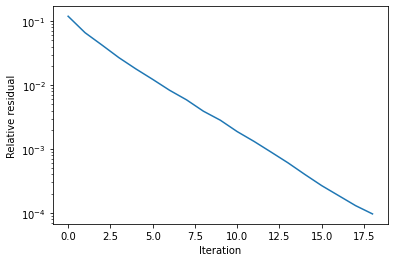

In [5]:
import matplotlib.pyplot as plt

X = torch.randn(10,64,32,32)
f = ResNetLayer(64,128)
Z, res = anderson(lambda Z : f(Z,X), torch.zeros_like(X), tol=1e-4, beta=1.0)
plt.semilogy(res)
plt.xlabel("Iteration")
plt.ylabel("Relative residual")

We can compare this to the naive forward iteration, to see some of the advantages of Anderson acceleration.  Beacuse this systemm is relatively stable, the difference (2x the iterations) is not _that_ substantial, but as training of the full DEQ model progresses, the differences between Anderson acceleration and simple forward interation becomes even more stark.

Text(0, 0.5, 'Relative residual')

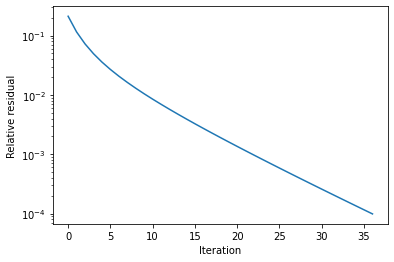

In [6]:
def forward_iteration(f, x0, max_iter=50, tol=1e-2):
    f0 = f(x0)
    res = []
    for k in range(max_iter):
        x = f0
        f0 = f(x)
        res.append((f0 - x).norm().item() / (1e-5 + f0.norm().item()))
        if (res[-1] < tol):
            break
    return f0, res

Z, res = forward_iteration(lambda Z : f(Z,X), torch.zeros_like(X), tol=1e-4)
plt.semilogy(res)
plt.xlabel("Iteration")
plt.ylabel("Relative residual")

### Implementing the backward pass

The backward pass, as described above, requires that we first find a solution to the linear fixed point equation
\begin{equation}
g = \left(\frac{\partial f(z^\star, x)}{\partial z^\star} \right )^T g + y.
\end{equation}
and then that we compute the final vector Jacobian product as
\begin{equation}
\left (\frac{\partial z^\star(\cdot)}{\partial (\cdot)} \right)^T y = \left (\frac{\partial f(z^\star, x)}{\partial (\cdot)} \right )^T g.
\end{equation}
The two vector-Jacobian product in each of these terms $\left(\frac{\partial f(z^\star, x)}{\partial z^\star} \right )^T g$ and $\left (\frac{\partial f(z^\star, x)}{\partial (\cdot)} \right )^T g$ are both "standard" vector-Jacobian products that can be computed using existing automatic differentation tools.

This means that implementing a generic DEQ layer, capable of using any function $f$, inside a library like PyTorch is actually very straightforward.  All of it can be done within a standard `nn.Module` class (rather than e.g., an explicit `autograd.Function` class that requires separate implementation of forward/backward passes), exploiting the built-in automatic differentiation tools to compute all needed derivatives.  It essentially involves three steps, which we described in a less generic (and less elegant, since we computed the Jacobian explicitly) form in Chapter 1, but which we now highlight again.
1. Compute the fixed point $z^\star = f(z^\star,x)$ (using e.g. Anderson acceleration), _outside_ the autodiff tape (in PyTorch, this means running it inside of a `with torch.no_grad():` block).
2. Re-engage the autodiff tape by calling $z := f(z,x)$ once, at the equilibrium point.  This engages the existing automatic differentiation library to compute the $\left (\frac{\partial f(z^\star, x)}{\partial (\cdot)} \right )^T$ multiplication.
3. Add a backwards hook that takes the incoming backward gradient $y$ and solve the fixed point equation $g = \left(\frac{\partial f(z^\star, x)}{\partial z^\star} \right )^T g + y$ again using, e.g. Anderson Acceleration.
In total, the code is quite short, and looks like the following.

In [7]:
import torch.autograd as autograd

class DEQFixedPoint(nn.Module):
    def __init__(self, f, solver, **kwargs):
        super().__init__()
        self.f = f
        self.solver = solver
        self.kwargs = kwargs
        
    def forward(self, x):
        # compute forward pass and re-engage autograd tape
        with torch.no_grad():
            z, self.forward_res = self.solver(lambda z : self.f(z, x), torch.zeros_like(x), **self.kwargs)
        z = self.f(z,x)
        
        # set up Jacobian vector product (without additional forward calls)
        z0 = z.clone().detach().requires_grad_()
        f0 = self.f(z0,x)
        def backward_hook(grad):
            g, self.backward_res = self.solver(lambda y : autograd.grad(f0, z0, y, retain_graph=True)[0] + grad,
                                               grad, **self.kwargs)
            return g
                
        z.register_hook(backward_hook)
        return z

For those familiar with PyTorch, you may note that we prefer to call `autograd.grad` directly (rather than the higher order functions `autograd.functions.vjp`, etc) because it lets us repeatedly multiply by this Jacobian without re-running the forward pass.  One minor downside of the simplicity here is that it does require two additional calls to $f$ than are strictly necessary: once to re-engage the gradient tape as described in Step 2 above, and once to set up the `f0` variable (which needs to be separate from `z`).  However, given that we typically need to call $f$ multiple times for the forward solve itself, this adds relatively little computational overhead.


To verify that this layer is computing gradients correctly, we can use the `gradcheck` function to verify that the analytic gradients match with numerically computed gradients.  Note that owning to our use of `nn.Module` in this somewhat non-standard manner (as opposed to an `autograd.Function` class), this will only test gradients with respect to the input to the layer $x$ (and not with respect to the parameters), though we could also verify those by setting up a separate function if needed.  We should also emphasize that the function above will _not_ work with double backprop, though again this can be adressed with some additional effect if needed.

In [8]:
from torch.autograd import gradcheck
# run a very small network with double precision, iterating to high precision
f = ResNetLayer(2,2, num_groups=2).double()
deq = DEQFixedPoint(f, anderson, tol=1e-10, max_iter=500).double()
gradcheck(deq, torch.randn(1,2,3,3).double().requires_grad_(), check_undefined_grad=False)

True

Finally, let's take a look at using the layer above to compute a forward and backward pass, and look at the relative residuals for both the forward and backward iterations.

In [9]:
f = ResNetLayer(64,128)
deq = DEQFixedPoint(f, anderson, tol=1e-4, max_iter=100, beta=2.0)
X = torch.randn(10,64,32,32)
out = deq(X)
(out*torch.randn_like(out)).sum().backward()

Text(0, 0.5, 'Residual')

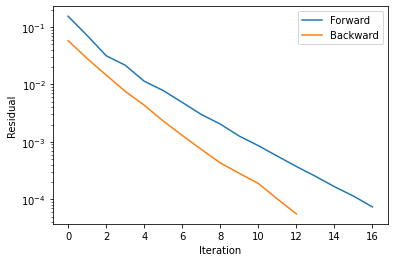

In [10]:
plt.semilogy(deq.forward_res)
plt.semilogy(deq.backward_res)
plt.legend(['Forward', 'Backward'])
plt.xlabel("Iteration")
plt.ylabel("Residual")

Here we see that (perhaps not too surprisingly, owning to the fact is it solving a linear rather than a nonlinear system), the backward pass typically converges a bit faster than the forward pass; however, this will not always be the case in practice, and indeed we will see below that after training, the backward pass frequently in fact converges to lower precision that the forward pass.

## Training your DEQ

Let's finally put all of this together to actually train a convolutional DEQ model on CIFAR10.  The following code will take a few hours to run on a single GPU, which may seem exessive for a model that achieve only slightly larger than 80% accuracy, though we should make the following caveats:
1. We are effectively running a _fully convolutional_ network on CIFAR10 here, which maintains reasonbly large channels for the whole 32x32 image without down sampling.  Most reasonable networks do a large amount of downsampling before having any high-channel-count layers, and while we could also certainly do this for the DEQ, we wanted to emphasize the simplicty of a model that simply performs convolutions over the original input scale.
2. The model is very small, with less than 100K parameters.  ResNets of this size achieve a comparable level of accuracy.
3. We are using no data augmentation (though for a model this small, adding data augmentation only gives a relatively small benefit).

Addressing both points above, and incorporating a cell $f$ the integrates information at multiple scales, one can achieve results competetive with the state of the art [[Bai et al., 2020](https://arxiv.org/abs/2006.08656)] (though, it should be emphasized, with runtimes that _are_ indeed still slower than comparable feedforward models with the same number of paraemters).

The following model demonstrates the full DEQ model we consider, with a DEQ layer applied to the residual cell described above, a convolutional input injection, and a linear layer applied after average pooling of the DEQ output.  In pratice, it's also important to apply some form of normalization before and after the DEQ layer: here we simply use Batch Norm, which works well to "standardize" the size of the input as seen by the fixed point iteration.

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

torch.manual_seed(0)
chan = 48
f = ResNetLayer(chan, 64, kernel_size=3)
model = nn.Sequential(nn.Conv2d(3,chan, kernel_size=3, bias=True, padding=1),
                      nn.BatchNorm2d(chan),
                      DEQFixedPoint(f, anderson, tol=1e-2, max_iter=25, m=5),
                      nn.BatchNorm2d(chan),
                      nn.AvgPool2d(8,8),
                      nn.Flatten(),
                      nn.Linear(chan*4*4,10)).to(device)

Now let's include the boilerplate dataloader and training code.  There's nothing particularly fancy here: we are no data augmentation, a cosine annealing learning rate schedule, and training with the Adam optimizer for 50 epochs (these element can all very likely be improved upon).

In [12]:
# CIFAR10 data loader
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

cifar10_train = datasets.CIFAR10(".", train=True, download=True, transform=transforms.ToTensor())
cifar10_test = datasets.CIFAR10(".", train=False, download=True, transform=transforms.ToTensor())
train_loader = DataLoader(cifar10_train, batch_size = 100, shuffle=True, num_workers=8)
test_loader = DataLoader(cifar10_test, batch_size = 100, shuffle=False, num_workers=8)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./cifar-10-python.tar.gz to .
Files already downloaded and verified


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [13]:
# standard training or evaluation loop
def epoch(loader, model, opt=None, lr_scheduler=None):
    total_loss, total_err = 0.,0.
    model.eval() if opt is None else model.train()
    for X,y in loader:
        X,y = X.to(device), y.to(device)
        yp = model(X)
        loss = nn.CrossEntropyLoss()(yp,y)
        if opt:
            opt.zero_grad()
            loss.backward()
            opt.step()
            lr_scheduler.step()
                
        total_err += (yp.max(dim=1)[1] != y).sum().item()
        total_loss += loss.item() * X.shape[0]

    return total_err / len(loader.dataset), total_loss / len(loader.dataset)

The following code will now train a model to ~81% accuracy over 50 epochs.  Again, this code will take a few hours to run on a single GPU (and likely longer in Colab), but it hopefully gives an impression of the relative ease of building these medium-scale DEQ models.

In [ ]:
import torch.optim as optim
opt = optim.Adam(model.parameters(), lr=1e-3)
print("# Parmeters: ", sum(a.numel() for a in model.parameters()))

max_epochs = 50
scheduler = optim.lr_scheduler.CosineAnnealingLR(opt, max_epochs*len(train_loader), eta_min=1e-6)

for i in range(50):
    print(epoch(train_loader, model, opt, scheduler))
    print(epoch(test_loader, model)) 

# Parmeters:  64842


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


(0.4501, 1.2674702651500702)
(0.3571, 1.0114790272712708)
(0.30414, 0.8737036627531052)
(0.3003, 0.8557280349731445)
(0.26034, 0.7487140709161758)
(0.2717, 0.7894439023733139)
(0.2339, 0.675908499121666)
(0.2428, 0.7142932930588722)
(0.21502, 0.6207390862703324)
(0.2562, 0.7419076782464981)
(0.20204, 0.579071974515915)
(0.243, 0.6983418616652489)
(0.18998, 0.5466646602153779)
(0.2317, 0.672813461124897)
(0.17918, 0.5197847720980644)
(0.2272, 0.6634527841210365)
(0.17158, 0.49474316799640655)
(0.2213, 0.6405157232284546)
(0.16206, 0.46802975022792814)
(0.225, 0.6560679683089257)
(0.15542, 0.44882389414310453)
(0.2085, 0.6201595851778984)
(0.14508, 0.422962179929018)
(0.2369, 0.7059007978439331)
(0.14116, 0.4085836258530617)
(0.2101, 0.6336100253462792)
(0.13642, 0.3907997935116291)
(0.2127, 0.6314669808745385)
(0.1346, 0.3832421867251396)
(0.2037, 0.6172784173488617)
(0.12786, 0.3668717278242111)
(0.2276, 0.6906419438123703)
(0.1248, 0.35669610857963563)
(0.2059, 0.6300762009620666)
(0.